In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [5]:

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    func = 1/5 * a[4] * cp.power(y_el[0] + y_el[1] + y_in[0], 5)
    func += 1/4 * a[3] * cp.power(y_el[0] + y_el[1] + y_in[0], 4)
    func += 1/3 * a[2] * cp.power(y_el[0] + y_el[1] + y_in[0], 3)
    func += 1/2 * a[1] * cp.power(y_el[0] + y_el[1] + y_in[0], 2)
    func += a[0] * (y_el[0] + y_el[1] + y_in[0])
    func += y_in[0] * tau / v_I + y_el[0] * tau / v_E
    func += 1/5 * a[4] * cp.power(y_el[2] + y_in[1], 5)
    func += 1/4 * a[3] * cp.power(y_el[2] + y_in[1], 4)
    func += 1/3 * a[2] * cp.power(y_el[2] + y_in[1], 3)
    func += 1/2 * a[1] * cp.power(y_el[2] + y_in[1], 2)
    func += a[0] * (y_el[2] + y_in[1])

    objective = cp.Minimize(func)
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
#     # The optimal value for x is stored in `x.value`.
#     print("In solve_CBCP_direct, y_el.value:", y_el.value)
#     print("In solve_CBCP_direct, y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [6]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[4] * (y_el[0] + y_el[1] + y_in[0])**4 \
            + a[3] * (y_el[0] + y_el[1] + y_in[0])**3 \
            + a[2] * (y_el[0] + y_el[1] + y_in[0])**2 \
            + a[1] * (y_el[0] + y_el[1] + y_in[0]) \
            + a[0]
        
    ell_2 = a[4] * (y_el[2] + y_in[1])**4 \
            + a[3] * (y_el[2] + y_in[1])**3 \
            + a[2] * (y_el[2] + y_in[1])**2 \
            + a[1] * (y_el[2] + y_in[1]) \
            + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    obj_R = tau * (y_el[0] + y_in[0])
    obj_I = tau * y_in[0] + v_I * (ell_1 * (y_el[0] + y_el[1] + y_el[2]) + ell_2 * (y_in[0] + y_in[1]) )
    
#     print()
#     print("tau:", tau)
#     print("y_el.shape:", y_el.shape)
#     print("y_in.shape:", y_in.shape)
#     print("ell_1:", ell_1)
#     print("ell_2:", ell_2)
#     print("obj_E.shape:", obj_E.shape)
#     print("obj_R.shape:", obj_R.shape)
#     print("obj_I.shape:", obj_I.shape)
#     print()

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [7]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    # Case 1:
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    # Case 2:
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    # Case 3:
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    # Case 4:
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    # Case 5:
    elif 0 <= B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    # Case 6:
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

In [8]:
# arr_temp = np.zeros(5)
# arr_temp[0] = 1

## Chinmay's Algorithm:

In [30]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 0.5
delta_bar = 0.5

welfare_list = []

tau[0] = 0.8
B[0] = 0.2

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] < B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])


    y_el, y_in = solve_CBCP_direct_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a)
    

#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_direct_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a)
    
#     print("y_el:", y_el)
#     print("y_in:", y_in)
#     print("y_el_perturbed:", y_el_perturbed)
#     print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I = v_I, v_E = v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    welfare_list.append(welfare)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
#         print("tau[0:10]:", tau[0:10])
#         print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

min_welfare = min(welfare_list)
argmin_welfare_list = welfare_list.index(min(welfare_list))
argmin_tau = tau[argmin_welfare_list]
argmin_B = B[argmin_welfare_list]

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [-0.78273343  0.62235712]
tau[i]: 0.8
B[i]: 0.2
tau_perturbed[i]: 0.5232619428012828
B_perturbed[i]: 0.4200364690179324
welfare: 2.6128483299040655
welfare_perturbed: 2.5366135214849725

Iter: 1
w_i: [0.58535954 0.81077383]
tau[i]: 0.7156117089087353
B[i]: 0.267097752243183
tau_perturbed[i]: 0.8896401427042111
B_perturbed[i]: 0.5081422541074905
welfare: 2.5849743201789
welfare_perturbed: 2.6088716825604705

Iter: 2
w_i: [-0.92963492  0.36848191]
tau[i]: 0.6989764267203048
B[i]: 0.2440564409986371
tau_perturbed[i]: 0.44923699375178516
B_perturbed[i]: 0.34304633578222343
welfare: 2.583574674685443
welfare_perturbed: 2.5373348770999185

Iter: 3
w_i: [0.45683247 0.88955275]
tau[i]: 0.6527848234019527
B[i]: 0.2623655317898588
tau_perturbed[i]: 0.7669929396592495
B_perturbed[i]: 0.4847537198326588
welfare: 2.572299342550351
welfare_perturbed: 2.575625410942124

Iter: 4
w_i: [ 0.10692976 -0.99426658]
tau[i]: 0.6512653673796833
B[i]: 0.2594068184980474
tau_perturbed[i]: 0.6765473

welfare: 2.542798054005422
welfare_perturbed: 2.538632413840086
tau_diffs: [0.01911856 0.00096308 0.01703003 0.01085246]
B_diffs: [-0.00291978 -0.01110619 -0.00664409 -0.0119704 ]

Iter: 28
w_i: [-0.51164401 -0.85919753]
tau[i]: 0.4868865889879817
B[i]: 0.32087182790959956
tau_perturbed[i]: 0.4089352814504823
B_perturbed[i]: 0.18996915060571218
welfare: 2.5426995064843902
welfare_perturbed: 2.5502167743158948
tau_diffs: [0.00096308 0.01703003 0.01085246 0.00683874]
B_diffs: [-0.01110619 -0.00664409 -0.0119704   0.00340802]

Iter: 29
w_i: [ 0.70319157 -0.71100043]
tau[i]: 0.48923051241428317
B[i]: 0.3248079498502169
tau_perturbed[i]: 0.5954607978116911
B_perturbed[i]: 0.21739798898174253
welfare: 2.54252939883506
welfare_perturbed: 2.5667747575685826
tau_diffs: [ 0.01703003  0.01085246  0.00683874 -0.00129699]
B_diffs: [-0.00664409 -0.0119704   0.00340802 -0.00220827]

Iter: 30
w_i: [-0.95717186 -0.28952033]
tau[i]: 0.47892814690298463
B[i]: 0.335224721981456
tau_perturbed[i]: 0.3355098

welfare: 2.542779546410431
welfare_perturbed: 2.534191202984381
tau_diffs: [ 0.00357501  0.00283918  0.00249711 -0.00089581]
B_diffs: [ 0.00222177  0.00041723  0.00043794 -0.00603998]

Iter: 52
w_i: [ 0.8817801  -0.47166075]
tau[i]: 0.4740192242063789
B[i]: 0.31300562571218565
tau_perturbed[i]: 0.5895629401241435
B_perturbed[i]: 0.25120174067652595
welfare: 2.5423174259933052
welfare_perturbed: 2.5624750856697585
tau_diffs: [ 0.00283918  0.00249711 -0.00089581  0.00346709]
B_diffs: [ 0.00041723  0.00043794 -0.00603998  0.00203416]

Iter: 53
w_i: [-0.60002086 -0.79998436]
tau[i]: 0.46470286059348653
B[i]: 0.3179889124371115
tau_perturbed[i]: 0.3864459113940709
B_perturbed[i]: 0.21365198063444457
welfare: 2.5410341397314444
welfare_perturbed: 2.546910542854013
tau_diffs: [ 0.00249711 -0.00089581  0.00346709  0.00447303]
B_diffs: [ 0.00043794 -0.00603998  0.00203416 -0.00067024]

Iter: 54
w_i: [-0.70557574 -0.70863451]
tau[i]: 0.466542338116039
B[i]: 0.32044141592448916
tau_perturbed[i]: 

welfare: 2.54672105009252
welfare_perturbed: 2.5669532790278637
tau_diffs: [-0.00094846 -0.00103637 -0.01722391 -0.00122176]
B_diffs: [-0.0017906  -0.00436829  0.01715552 -0.00240351]

Iter: 76
w_i: [ 0.89927169 -0.43739048]
tau[i]: 0.5078602013517202
B[i]: 0.31614455201995706
tau_perturbed[i]: 0.6151907245463152
B_perturbed[i]: 0.26394080839721246
welfare: 2.545287076973293
welfare_perturbed: 2.565358498400185
tau_diffs: [-0.00103637 -0.01722391 -0.00122176 -0.00011203]
B_diffs: [-4.36828875e-03  1.71555230e-02 -2.40351050e-03 -9.85532564e-05]

Iter: 77
w_i: [-0.42860988  0.90348966]
tau[i]: 0.4992430966996902
B[i]: 0.3203357653732111
tau_perturbed[i]: 0.4482520957551998
B_perturbed[i]: 0.4278224191935177
welfare: 2.543967189410552
welfare_perturbed: 2.5327964573459916
tau_diffs: [-0.01722391 -0.00122176 -0.00011203  0.00721737]
B_diffs: [ 1.71555230e-02 -2.40351050e-03 -9.85532564e-05 -6.46679023e-03]

Iter: 78
w_i: [-0.85056016 -0.52587776]
tau[i]: 0.4969646694626716
B[i]: 0.3251385

welfare: 2.5421239885947706
welfare_perturbed: 2.540455403330882
tau_diffs: [-0.00139772 -0.00670047  0.00117727  0.00611463]
B_diffs: [-0.00204428  0.02391253  0.00032132 -0.0002693 ]

Iter: 100
w_i: [-0.84851609  0.52916958]
tau[i]: 0.4608517414812193
B[i]: 0.30432915610517713
tau_perturbed[i]: 0.36622045480358195
B_perturbed[i]: 0.3633451239389734
welfare: 2.542090526992762
welfare_perturbed: 2.5824131082976165
tau_diffs: [-0.00670047  0.00117727  0.00611463  0.00094684]
B_diffs: [ 0.02391253  0.00032132 -0.0002693  -0.0055091 ]

Iter: 101
w_i: [-0.9860188   0.16663413]
tau[i]: 0.4761148524853875
B[i]: 0.2948104514601254
tau_perturbed[i]: 0.36641901258454224
B_perturbed[i]: 0.31334870908204215
welfare: 2.544320247799567
welfare_perturbed: 2.5363563565536245
tau_diffs: [0.00117727 0.00611463 0.00094684 0.00071008]
B_diffs: [ 0.00032132 -0.0002693  -0.0055091   0.00022939]

Iter: 102
w_i: [0.40915336 0.91246563]
tau[i]: 0.47262042952897687
B[i]: 0.29540099813048626
tau_perturbed[i]: 0

welfare: 2.541102139628923
welfare_perturbed: 2.530076697896935
tau_diffs: [-0.00990118  0.00619196  0.00491286  0.00337508]
B_diffs: [ 0.02362819 -0.00288371  0.00042804 -0.00527303]

Iter: 124
w_i: [ 0.92092545 -0.38973877]
tau[i]: 0.46186259499365695
B[i]: 0.31988167055694056
tau_perturbed[i]: 0.5592386058183176
B_perturbed[i]: 0.2786718124720781
welfare: 2.5406156684405152
welfare_perturbed: 2.5553077076452806
tau_diffs: [0.00619196 0.00491286 0.00337508 0.00251558]
B_diffs: [-0.00288371  0.00042804 -0.00527303 -0.00015161]

Iter: 125
w_i: [-0.76552057  0.64341142]
tau[i]: 0.4561399863190987
B[i]: 0.32230349795936303
tau_perturbed[i]: 0.3827788536454928
B_perturbed[i]: 0.3827788536454928
welfare: 2.539926204032838
welfare_perturbed: 2.59993597706711
tau_diffs: [0.00491286 0.00337508 0.00251558 0.00024733]
B_diffs: [ 0.00042804 -0.00527303 -0.00015161 -0.00466602]

Iter: 126
w_i: [-0.22610451  0.97410305]
tau[i]: 0.47553103128164104
B[i]: 0.30600554320637546
tau_perturbed[i]: 0.4517

welfare: 2.5422296116948155
welfare_perturbed: 2.557040339655097
tau_diffs: [ 0.00243509 -0.01322971 -0.01204304  0.00350801]
B_diffs: [-0.00486096  0.00249541  0.02058381 -0.00349628]

Iter: 148
w_i: [-0.82105321 -0.57085166]
tau[i]: 0.4722982262643781
B[i]: 0.3203612824555399
tau_perturbed[i]: 0.38921186390640616
B_perturbed[i]: 0.2625940305163331
welfare: 2.5414330983820643
welfare_perturbed: 2.5421142768229945
tau_diffs: [-0.01322971 -0.01204304  0.00350801  0.00040618]
B_diffs: [ 0.00249541  0.02058381 -0.00349628 -0.00441424]

Iter: 149
w_i: [ 0.79872245 -0.60169963]
tau[i]: 0.4725246128194724
B[i]: 0.320518681681991
tau_perturbed[i]: 0.5532161677873055
B_perturbed[i]: 0.2597315101861093
welfare: 2.5414368432945715
welfare_perturbed: 2.5563854805478705
tau_diffs: [-0.01204304  0.00350801  0.00040618  0.00391869]
B_diffs: [ 0.02058381 -0.00349628 -0.00441424 -0.00455039]

Iter: 150
w_i: [-0.9713626   0.23760196]
tau[i]: 0.4676996976809973
B[i]: 0.32415342318737506
tau_perturbed[i]

welfare: 2.5395902087128874
welfare_perturbed: 2.552055697440342
tau_diffs: [ 0.00430799 -0.0013376   0.00434062 -0.00111738]
B_diffs: [-0.0031657   0.01329186 -0.00293041  0.00740098]

Iter: 172
w_i: [0.778551   0.62758135]
tau[i]: 0.4416773185889418
B[i]: 0.32110127638990693
tau_perturbed[i]: 0.5175753559747304
B_perturbed[i]: 0.3822818446845604
welfare: 2.5390027087852447
welfare_perturbed: 2.539736467741188
tau_diffs: [-0.0013376   0.00434062 -0.00111738  0.0026459 ]
B_diffs: [ 0.01329186 -0.00293041  0.00740098  0.00066761]

Iter: 173
w_i: [-0.71051379  0.70368328]
tau[i]: 0.44145455513026044
B[i]: 0.3209217092302433
tau_perturbed[i]: 0.3808556713051666
B_perturbed[i]: 0.3808556713051666
welfare: 2.539005566612115
welfare_perturbed: 2.599935742475674
tau_diffs: [ 0.00434062 -0.00111738  0.0026459   0.00234036]
B_diffs: [-0.00293041  0.00740098  0.00066761 -0.0042684 ]

Iter: 174
w_i: [ 0.93368206 -0.35810306]
tau[i]: 0.45831164594215307
B[i]: 0.30422667361504424
tau_perturbed[i]: 

welfare: 2.539555753607552
welfare_perturbed: 2.552654536696273
tau_diffs: [ 4.74483041e-04 -2.98568709e-04 -9.06333007e-05 -6.67225318e-04]
B_diffs: [-0.00392452 -0.00020302  0.00044953 -0.00107549]

Iter: 196
w_i: [ 0.99405305 -0.10889686]
tau[i]: 0.45980991134580107
B[i]: 0.33517554178164183
tau_perturbed[i]: 0.5536196689515651
B_perturbed[i]: 0.32489883868986663
welfare: 2.538920223435405
welfare_perturbed: 2.549921795447918
tau_diffs: [-2.98568709e-04 -9.06333007e-05 -6.67225318e-04 -8.07231190e-04]
B_diffs: [-0.00020302  0.00044953 -0.00107549  0.00317943]

Iter: 197
w_i: [0.92378794 0.38290449]
tau[i]: 0.4556816921306962
B[i]: 0.33562778133810334
tau_perturbed[i]: 0.5427501788288812
B_perturbed[i]: 0.3717171399576708
welfare: 2.5385554996978406
welfare_perturbed: 2.5438163861308096
tau_diffs: [-9.06333007e-05 -6.67225318e-04 -8.07231190e-04  3.01088083e-03]
B_diffs: [ 0.00044953 -0.00107549  0.00317943 -0.00393011]

Iter: 198
w_i: [-0.9313104  0.3642265]
tau[i]: 0.45384946244905

welfare: 2.5403710391683902
welfare_perturbed: 2.5398785323181876
tau_diffs: [ 8.48517412e-05 -1.92298753e-02 -1.11913426e-02  1.95375585e-03]
B_diffs: [-0.00347552  0.00341841  0.00675528 -0.00271541]

Iter: 220
w_i: [0.7214939 0.6924208]
tau[i]: 0.48663352956697814
B[i]: 0.3439599901540202
tau_perturbed[i]: 0.5527926311591393
B_perturbed[i]: 0.4074531646019245
welfare: 2.540366629937716
welfare_perturbed: 2.541552255798523
tau_diffs: [-0.01922988 -0.01119134  0.00195376  0.00191461]
B_diffs: [ 0.00341841  0.00675528 -0.00271541  0.00021601]

Iter: 221
w_i: [0.99817428 0.06039958]
tau[i]: 0.4863197697998764
B[i]: 0.34365887355557945
tau_perturbed[i]: 0.577746489425644
B_perturbed[i]: 0.3491911089669289
welfare: 2.5403671279716233
welfare_perturbed: 2.5508919350695094
tau_diffs: [-0.01119134  0.00195376  0.00191461  0.00015136]
B_diffs: [ 6.75527923e-03 -2.71540754e-03  2.16010849e-04  9.89804443e-05]

Iter: 222
w_i: [0.56004338 0.82846329]
tau[i]: 0.48247077544926154
B[i]: 0.343425970

welfare: 2.5392347891263536
welfare_perturbed: 2.5743236578736473
tau_diffs: [0.0018103  0.00313833 0.00073421 0.00083868]
B_diffs: [-0.00376521 -0.00100958 -0.00373439  0.00035931]

Iter: 244
w_i: [0.97562836 0.21942949]
tau[i]: 0.5014164614396622
B[i]: 0.3520470305974774
tau_perturbed[i]: 0.588602692123308
B_perturbed[i]: 0.371656167286209
welfare: 2.5410158576294184
welfare_perturbed: 2.5502850196107483
tau_diffs: [ 0.00313833  0.00073421  0.00083868 -0.00052654]
B_diffs: [-0.00100958 -0.00373439  0.00035931 -0.00234439]

Iter: 245
w_i: [-0.25168682 -0.96780873]
tau[i]: 0.498183888260669
B[i]: 0.3513199895403498
tau_perturbed[i]: 0.4757149938998274
B_perturbed[i]: 0.2649205815592006
welfare: 2.5407612881663253
welfare_perturbed: 2.547274112818908
tau_diffs: [ 0.00073421  0.00083868 -0.00052654 -0.00891576]
B_diffs: [-0.00373439  0.00035931 -0.00234439  0.00884036]

Iter: 246
w_i: [-0.993903    0.11025798]
tau[i]: 0.4987692321371073
B[i]: 0.3535708063174225
tau_perturbed[i]: 0.410130

welfare: 2.539619307836261
welfare_perturbed: 2.535429091646507
tau_diffs: [ 0.00314885  0.00161164 -0.00070727  0.00141937]
B_diffs: [ 0.00055558  0.00083856 -0.00167391 -0.00354903]

Iter: 268
w_i: [-0.92836465 -0.37167067]
tau[i]: 0.4840356418510475
B[i]: 0.35002584886299437
tau_perturbed[i]: 0.40298890580246916
B_perturbed[i]: 0.31757879835769853
welfare: 2.5395131401804867
welfare_perturbed: 2.537173792768913
tau_diffs: [ 0.00161164 -0.00070727  0.00141937  0.00090337]
B_diffs: [ 0.00083856 -0.00167391 -0.00354903  0.00032977]

Iter: 269
w_i: [0.98048871 0.19657538]
tau[i]: 0.48327725596228055
B[i]: 0.3497222291685433
tau_perturbed[i]: 0.5687950844825991
B_perturbed[i]: 0.3668674544017304
welfare: 2.53947318656153
welfare_perturbed: 2.547823451287636
tau_diffs: [-0.00070727  0.00141937  0.00090337  0.00143749]
B_diffs: [-0.00167391 -0.00354903  0.00032977  0.00028049]

Iter: 270
w_i: [0.1326526  0.99116259]
tau[i]: 0.48042086993449495
B[i]: 0.3491495604906
tau_perturbed[i]: 0.4919

welfare: 2.5397595408892957
welfare_perturbed: 2.5359959822702662
tau_diffs: [-0.00011322 -0.00207106  0.00019088 -0.01025524]
B_diffs: [-0.00012567  0.0074379   0.00010692  0.00731009]

Iter: 292
w_i: [-0.6090571   0.79312638]
tau[i]: 0.482463743775157
B[i]: 0.3467384413780403
tau_perturbed[i]: 0.4304166948602727
B_perturbed[i]: 0.4145151532502901
welfare: 2.539696556514986
welfare_perturbed: 2.5390698348941516
tau_diffs: [-0.00207106  0.00019088 -0.01025524  0.001769  ]
B_diffs: [ 0.0074379   0.00010692  0.00731009 -0.00356584]

Iter: 293
w_i: [-0.92760805 -0.37355495]
tau[i]: 0.4823332677317347
B[i]: 0.34690834990091785
tau_perturbed[i]: 0.4031318995336596
B_perturbed[i]: 0.31501334528341557
welfare: 2.539667562037458
welfare_perturbed: 2.537436962612998
tau_diffs: [ 0.00019088 -0.01025524  0.001769   -0.00057092]
B_diffs: [ 0.00010692  0.00731009 -0.00356584 -0.00115406]

Iter: 294
w_i: [-0.99830024 -0.05828071]
tau[i]: 0.4816266016264583
B[i]: 0.346623769985146
tau_perturbed[i]: 0

welfare: 2.538862134066493
welfare_perturbed: 2.542541687482563
tau_diffs: [-0.00245131  0.00132905 -0.00592797  0.00249995]
B_diffs: [ 0.00702433  0.00024115  0.00760028 -0.00326223]

Iter: 316
w_i: [-0.6686971  -0.74353493]
tau[i]: 0.480048651499349
B[i]: 0.35332992565816274
tau_perturbed[i]: 0.4240187794375477
B_perturbed[i]: 0.2910294209209633
welfare: 2.5388167888261375
welfare_perturbed: 2.5409051992320615
tau_diffs: [ 0.00132905 -0.00592797  0.00249995  0.00376218]
B_diffs: [ 0.00024115  0.00760028 -0.00326223 -0.00160308]

Iter: 317
w_i: [-0.98737352  0.15840941]
tau[i]: 0.4805167049707748
B[i]: 0.35385036174771267
tau_perturbed[i]: 0.3978501764676718
B_perturbed[i]: 0.3671129780580873
welfare: 2.538807203803672
welfare_perturbed: 2.5319972927188394
tau_diffs: [-0.00592797  0.00249995  0.00376218 -0.00065544]
B_diffs: [ 0.00760028 -0.00326223 -0.00160308 -0.00104579]

Iter: 318
w_i: [ 0.21636771 -0.97631195]
tau[i]: 0.4782648981355832
B[i]: 0.3542116306990163
tau_perturbed[i]: 

welfare: 2.5397552617027035
welfare_perturbed: 2.545203260774895
tau_diffs: [ 3.12118558e-05  3.80022501e-04 -1.10547782e-04 -1.19313337e-02]
B_diffs: [-8.01024900e-05 -2.99675293e-03 -2.60701061e-03  1.24463583e-02]

Iter: 341
w_i: [-0.0645017 -0.9979176]
tau[i]: 0.4953089551810041
B[i]: 0.3592858989340087
tau_perturbed[i]: 0.49000597947713226
B_perturbed[i]: 0.2772425912902247
welfare: 2.5396723409075492
welfare_perturbed: 2.5473600054037266
tau_diffs: [ 0.00038002 -0.00011055 -0.01193133  0.00366321]
B_diffs: [-0.00299675 -0.00260701  0.01244636 -0.00218493]

Iter: 342
w_i: [-0.53528209 -0.84467336]
tau[i]: 0.49547202517317507
B[i]: 0.36180878462729704
tau_perturbed[i]: 0.451496180280762
B_perturbed[i]: 0.2924150481992237
welfare: 2.539436267740253
welfare_perturbed: 2.542566614585638
tau_diffs: [-0.00011055 -0.01193133  0.00366321  0.00161232]
B_diffs: [-0.00260701  0.01244636 -0.00218493  0.00078423]

Iter: 343
w_i: [-0.23463088  0.97208454]
tau[i]: 0.4960226637625035
B[i]: 0.3626

welfare: 2.5374425610181834
welfare_perturbed: 2.5487349729997177
tau_diffs: [ 0.00137784 -0.0004786   0.00039212  0.0004574 ]
B_diffs: [ 0.00024204 -0.00193947  0.00021244  0.00038059]

Iter: 365
w_i: [ 0.18395493 -0.98293468]
tau[i]: 0.48463385551180094
B[i]: 0.3761588305041501
tau_perturbed[i]: 0.49950334847521016
B_perturbed[i]: 0.2967059963971934
welfare: 2.5369550255387527
welfare_perturbed: 2.546356440761257
tau_diffs: [-0.0004786   0.00039212  0.0004574  -0.00044517]
B_diffs: [-0.00193947  0.00021244  0.00038059 -0.00077876]

Iter: 366
w_i: [-0.84319462  0.53760844]
tau[i]: 0.48407467840181245
B[i]: 0.37914670684032714
tau_perturbed[i]: 0.4192685035386089
B_perturbed[i]: 0.4192685035386089
welfare: 2.5366040704390445
welfare_perturbed: 2.599941719793725
tau_diffs: [ 0.00039212  0.0004574  -0.00044517  0.00181565]
B_diffs: [ 0.00021244  0.00038059 -0.00077876 -0.00317059]

Iter: 367
w_i: [-0.81407995  0.58075282]
tau[i]: 0.5013306035571412
B[i]: 0.36814458363999103
tau_perturbed

welfare: 2.539593257607291
welfare_perturbed: 2.5468768789903424
tau_diffs: [ 0.0014275  -0.0005483   0.00177656  0.00117015]
B_diffs: [-0.00317295 -0.00096213 -0.00314381  0.00031195]

Iter: 389
w_i: [0.68968766 0.72410699]
tau[i]: 0.5074959799646511
B[i]: 0.37477087692452393
tau_perturbed[i]: 0.5623667820072186
B_perturbed[i]: 0.4323800439683052
welfare: 2.539381463396739
welfare_perturbed: 2.5403628313752513
tau_diffs: [-0.0005483   0.00177656  0.00117015 -0.01459457]
B_diffs: [-0.00096213 -0.00314381  0.00031195  0.00899789]

Iter: 390
w_i: [ 0.96509695 -0.26189286]
tau[i]: 0.5072805861723316
B[i]: 0.37454473375730174
tau_perturbed[i]: 0.584013512738064
B_perturbed[i]: 0.353722157104541
welfare: 2.5393810941483492
welfare_perturbed: 2.551377231610617
tau_diffs: [ 0.00177656  0.00117015 -0.01459457 -0.0001824 ]
B_diffs: [-0.00314381  0.00031195  0.00899789 -0.00231221]

Iter: 391
w_i: [ 0.41064111 -0.91179706]
tau[i]: 0.5035985912324732
B[i]: 0.3755438957246822
tau_perturbed[i]: 0.5

welfare: 2.538300850320484
welfare_perturbed: 2.5463331010781247
tau_diffs: [ 0.00193746 -0.00842304  0.00265176  0.00351273]
B_diffs: [-0.00303867  0.00694662 -0.00147704 -0.00091448]

Iter: 413
w_i: [0.36093844 0.93258964]
tau[i]: 0.4975509716129149
B[i]: 0.37782550590136027
tau_perturbed[i]: 0.5258413046634378
B_perturbed[i]: 0.45092182520457735
welfare: 2.5380428731283433
welfare_perturbed: 2.5338244250594486
tau_diffs: [-0.00842304  0.00265176  0.00351273  0.00114043]
B_diffs: [ 0.00694662 -0.00147704 -0.00091448  0.00033209]

Iter: 414
w_i: [-0.70568022  0.70853047]
tau[i]: 0.4980283368162164
B[i]: 0.3790589180093921
tau_perturbed[i]: 0.44275051430473256
B_perturbed[i]: 0.4345600081726636
welfare: 2.5379677540563046
welfare_perturbed: 2.5625689783923935
tau_diffs: [2.65176072e-03 3.51273452e-03 1.14042882e-03 5.96038104e-05]
B_diffs: [-0.00147704 -0.00091448  0.00033209 -0.00251909]

Iter: 415
w_i: [-0.55258318 -0.83345776]
tau[i]: 0.5034679452658785
B[i]: 0.3735973389293756
tau_

welfare: 2.538431922896969
welfare_perturbed: 2.5310539016530362
tau_diffs: [ 0.00043352 -0.00043498  0.00030592  0.00293912]
B_diffs: [ 0.00037987 -0.00169981 -0.00264259 -0.00232104]

Iter: 437
w_i: [ 0.51610476 -0.85652547]
tau[i]: 0.49872990294646297
B[i]: 0.37780128220013287
tau_perturbed[i]: 0.5386162570079263
B_perturbed[i]: 0.31160604225210264
welfare: 2.538164696151103
welfare_perturbed: 2.5493088321371715
tau_diffs: [-0.00043498  0.00030592  0.00293912 -0.00424933]
B_diffs: [-0.00169981 -0.00264259 -0.00232104  0.00859647]

Iter: 438
w_i: [-0.72492225  0.68883069]
tau[i]: 0.49695190713186527
B[i]: 0.380752037222578
tau_perturbed[i]: 0.44095934912263246
B_perturbed[i]: 0.43395690491693983
welfare: 2.5376897975168893
welfare_perturbed: 2.567023176797777
tau_diffs: [ 0.00030592  0.00293912 -0.00424933  0.00225248]
B_diffs: [-0.00264259 -0.00232104  0.00859647 -0.0003665 ]

Iter: 439
w_i: [-0.93305925 -0.35972273]
tau[i]: 0.503521710895833
B[i]: 0.3745093229679053
tau_perturbed[i

welfare: 2.537958742730188
welfare_perturbed: 2.5532017502776574
tau_diffs: [0.00227194 0.00120615 0.00122284 0.00094828]
B_diffs: [-0.00092233 -0.00292031  0.00030367 -0.00286147]

Iter: 461
w_i: [ 0.37269257 -0.92795487]
tau[i]: 0.503849821720283
B[i]: 0.3784421023348877
tau_perturbed[i]: 0.5322712076648114
B_perturbed[i]: 0.3076766366331585
welfare: 2.5386288092583165
welfare_perturbed: 2.5489201185724863
tau_diffs: [ 0.00120615  0.00122284  0.00094828 -0.00270093]
B_diffs: [-0.00292031  0.00030367 -0.00286147  0.00628137]

Iter: 462
w_i: [-0.09631631  0.99535078]
tau[i]: 0.5026798486247128
B[i]: 0.3813551795200788
tau_perturbed[i]: 0.49533877508416285
B_perturbed[i]: 0.4572192111393145
welfare: 2.538215410754333
welfare_perturbed: 2.5298791006493313
tau_diffs: [ 0.00122284  0.00094828 -0.00270093 -0.00338218]
B_diffs: [ 0.00030367 -0.00286147  0.00628137  0.00319438]

Iter: 463
w_i: [-0.77354407  0.63374251]
tau[i]: 0.5024350587625622
B[i]: 0.38388488389365316
tau_perturbed[i]: 0.4

welfare: 2.538844635522385
welfare_perturbed: 2.53428969040329
tau_diffs: [ 0.00271205  0.00039001 -0.00036794 -0.01180769]
B_diffs: [ 0.00012279  0.000225   -0.0017448   0.01509144]

Iter: 485
w_i: [-0.79437595 -0.60742641]
tau[i]: 0.5032984306801299
B[i]: 0.37682483420729757
tau_perturbed[i]: 0.443481788848084
B_perturbed[i]: 0.3310855239231649
welfare: 2.5387329611279554
welfare_perturbed: 2.5381247308438226
tau_diffs: [ 0.00039001 -0.00036794 -0.01180769  0.00288226]
B_diffs: [ 2.25003457e-04 -1.74479778e-03  1.50914394e-02  5.94957247e-05]

Iter: 486
w_i: [0.24746984 0.9688956 ]
tau[i]: 0.5031529015079004
B[i]: 0.3767135540725369
tau_perturbed[i]: 0.5217778480533599
B_perturbed[i]: 0.4496340727661586
welfare: 2.538728916277802
welfare_perturbed: 2.5334801686756188
tau_diffs: [-0.00036794 -0.01180769  0.00288226  0.00134201]
B_diffs: [-1.74479778e-03  1.50914394e-02  5.94957247e-05  2.88461682e-04]

Iter: 487
w_i: [ 0.22390255 -0.97461154]
tau[i]: 0.5035439320819854
B[i]: 0.3782445

In [29]:
print("min(welfare_list):", min(welfare_list))
print("argmin_tau:", argmin_tau)
print("argmin_B:", argmin_B)

min(welfare_list): 2.534752761447937
argmin_tau: 0.48144224583570794
argmin_B: 0.3952456854634594


## Grid Search:

In [25]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0


grid_size = 0.02
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.ones((tau_arr.shape[0], B_arr.shape[0])) * 100
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_direct_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a)
            
#             def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.04
B: 0.02

tau: 0.06
B: 0.02

tau: 0.06
B: 0.04

tau: 0.08
B: 0.02

tau: 0.08
B: 0.04

tau: 0.08
B: 0.06

tau: 0.1
B: 0.02

tau: 0.1
B: 0.04

tau: 0.1
B: 0.06

tau: 0.1
B: 0.08

tau: 0.12
B: 0.02

tau: 0.12
B: 0.04

tau: 0.12
B: 0.06

tau: 0.12
B: 0.08

tau: 0.12
B: 0.1

tau: 0.14
B: 0.02

tau: 0.14
B: 0.04

tau: 0.14
B: 0.06

tau: 0.14
B: 0.08

tau: 0.14
B: 0.1

tau: 0.14
B: 0.12

tau: 0.16
B: 0.02

tau: 0.16
B: 0.04

tau: 0.16
B: 0.06

tau: 0.16
B: 0.08

tau: 0.16
B: 0.1

tau: 0.16
B: 0.12

tau: 0.16
B: 0.14

tau: 0.18
B: 0.02

tau: 0.18
B: 0.04

tau: 0.18
B: 0.06

tau: 0.18
B: 0.08

tau: 0.18
B: 0.1

tau: 0.18
B: 0.12

tau: 0.18
B: 0.14

tau: 0.18
B: 0.16

tau: 0.2
B: 0.02

tau: 0.2
B: 0.04

tau: 0.2
B: 0.06

tau: 0.2
B: 0.08

tau: 0.2
B: 0.1

tau: 0.2
B: 0.12

tau: 0.2
B: 0.14

tau: 0.2
B: 0.16

tau: 0.2
B: 0.18

tau: 0.22
B: 0.02

tau: 0.22
B: 0.04

tau: 0.22
B: 0.06

tau: 0.22
B: 0.08

tau: 0.22
B: 0.1

tau: 0.22
B: 0.12

tau: 0.22
B: 0.14

tau: 0.22
B: 0.16

tau: 0.22
B:


tau: 0.62
B: 0.14

tau: 0.62
B: 0.16

tau: 0.62
B: 0.18

tau: 0.62
B: 0.2

tau: 0.62
B: 0.22

tau: 0.62
B: 0.24

tau: 0.62
B: 0.26

tau: 0.62
B: 0.28

tau: 0.62
B: 0.3

tau: 0.62
B: 0.32

tau: 0.62
B: 0.34

tau: 0.62
B: 0.36

tau: 0.62
B: 0.38

tau: 0.62
B: 0.4

tau: 0.62
B: 0.42

tau: 0.62
B: 0.44

tau: 0.62
B: 0.46

tau: 0.62
B: 0.48

tau: 0.62
B: 0.5

tau: 0.62
B: 0.52

tau: 0.62
B: 0.54

tau: 0.62
B: 0.56

tau: 0.62
B: 0.58

tau: 0.62
B: 0.6

tau: 0.64
B: 0.02

tau: 0.64
B: 0.04

tau: 0.64
B: 0.06

tau: 0.64
B: 0.08

tau: 0.64
B: 0.1

tau: 0.64
B: 0.12

tau: 0.64
B: 0.14

tau: 0.64
B: 0.16

tau: 0.64
B: 0.18

tau: 0.64
B: 0.2

tau: 0.64
B: 0.22

tau: 0.64
B: 0.24

tau: 0.64
B: 0.26

tau: 0.64
B: 0.28

tau: 0.64
B: 0.3

tau: 0.64
B: 0.32

tau: 0.64
B: 0.34

tau: 0.64
B: 0.36

tau: 0.64
B: 0.38

tau: 0.64
B: 0.4

tau: 0.64
B: 0.42

tau: 0.64
B: 0.44

tau: 0.64
B: 0.46

tau: 0.64
B: 0.48

tau: 0.64
B: 0.5

tau: 0.64
B: 0.52

tau: 0.64
B: 0.54

tau: 0.64
B: 0.56

tau: 0.64
B: 0.58

ta


tau: 0.84
B: 0.02

tau: 0.84
B: 0.04

tau: 0.84
B: 0.06

tau: 0.84
B: 0.08

tau: 0.84
B: 0.1

tau: 0.84
B: 0.12

tau: 0.84
B: 0.14

tau: 0.84
B: 0.16

tau: 0.84
B: 0.18

tau: 0.84
B: 0.2

tau: 0.84
B: 0.22

tau: 0.84
B: 0.24

tau: 0.84
B: 0.26

tau: 0.84
B: 0.28

tau: 0.84
B: 0.3

tau: 0.84
B: 0.32

tau: 0.84
B: 0.34

tau: 0.84
B: 0.36

tau: 0.84
B: 0.38

tau: 0.84
B: 0.4

tau: 0.84
B: 0.42

tau: 0.84
B: 0.44

tau: 0.84
B: 0.46

tau: 0.84
B: 0.48

tau: 0.84
B: 0.5

tau: 0.84
B: 0.52

tau: 0.84
B: 0.54

tau: 0.84
B: 0.56

tau: 0.84
B: 0.58

tau: 0.84
B: 0.6

tau: 0.84
B: 0.62

tau: 0.84
B: 0.64

tau: 0.84
B: 0.66

tau: 0.84
B: 0.68

tau: 0.84
B: 0.7000000000000001

tau: 0.84
B: 0.72

tau: 0.84
B: 0.74

tau: 0.84
B: 0.76

tau: 0.84
B: 0.78

tau: 0.84
B: 0.8

tau: 0.84
B: 0.8200000000000001

tau: 0.86
B: 0.02

tau: 0.86
B: 0.04

tau: 0.86
B: 0.06

tau: 0.86
B: 0.08

tau: 0.86
B: 0.1

tau: 0.86
B: 0.12

tau: 0.86
B: 0.14

tau: 0.86
B: 0.16

tau: 0.86
B: 0.18

tau: 0.86
B: 0.2

tau: 0.86
B


tau: 1.0
B: 0.76

tau: 1.0
B: 0.78

tau: 1.0
B: 0.8

tau: 1.0
B: 0.8200000000000001

tau: 1.0
B: 0.84

tau: 1.0
B: 0.86

tau: 1.0
B: 0.88

tau: 1.0
B: 0.9

tau: 1.0
B: 0.92

tau: 1.0
B: 0.9400000000000001

tau: 1.0
B: 0.96

tau: 1.0
B: 0.98

Time: 76.24843001365662


In [26]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1]]


argmin_tau:
 0.68

argmin_B:
 0.64


2.529011865117637

Text(0, 0.5, 'Budget')

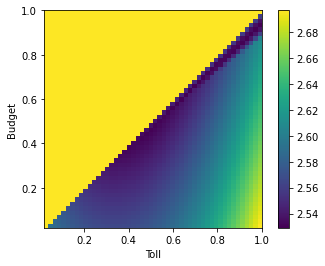

In [27]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

In [ ]:
# Test:

grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# Test:

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_elig = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_inel = cp.Variable(2)

a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

tau = 0.5
B = 0.4

func = 1/5 * a[4] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 5)
func += 1/4 * a[3] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 4)
func += 1/3 * a[2] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 3)
func += 1/2 * a[1] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 2)
func += a[0] * (y_elig[0] + y_elig[1] + y_inel[0])
func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
func += 1/5 * a[4] * cp.power(y_elig[2] + y_inel[1], 5)
func += 1/4 * a[3] * cp.power(y_elig[2] + y_inel[1], 4)
func += 1/3 * a[2] * cp.power(y_elig[2] + y_inel[1], 3)
func += 1/2 * a[1] * cp.power(y_elig[2] + y_inel[1], 2)
func += a[0] * (y_elig[2] + y_inel[1])

objective = cp.Minimize(func)


constraints = []
constraints += [y_elig >= 0, y_inel >= 0]
constraints += [cp.sum(y_elig) == 1, cp.sum(y_inel) == 1]
constraints += [y_elig[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("y_elig.value:", np.round(y_elig.value, 4) )
print("y_inel.value:", np.round(y_inel.value, 4) )
print()



# power(x, p)



# Frank-Wolfe Algorithm:

In [ ]:
# Below: For affine latency functions only:
def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
#     print()    
#     print("Starting solve_CBCP_iter_11:")
#     print()
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        if k % 100 == 0:
            print("Inner iter:", k)
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
#         print("grad:", grad)
#         print("y_el_var.value:", y_el_var.value)
#         print("y_in_var.value:", y_in_var.value)
#         print("y_el_var_current:", y_el_var_current)
#         print("y_in_var_current:", y_in_var_current)
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
#         print("y_el_var_current (new):", y_el_var_current)
#         print("y_in_var_current (new):", y_in_var_current)
#         print()
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        if k >= diffs_num_cols + 2:
            diffs = np.linalg.norm(y_iters[:, k-diffs_num_cols-1:k-2] - y_iters[:, k-diffs_num_cols:k-1], axis = 0)

            if np.max(diffs) < error_bound:
                break
    
    return y_el_var_current, y_in_var_current
